<center><h1> PDI - Production et Distribution Intégré </h1></center>
<center><h3> UE MAOA - Méthodes Avancées et applications industrielles
en Optimisation Combinatoire et en OrdonnAncement </h3></center>

<i>Etudiants :
 - Thomas Corcoral
 - Antoine Toullalan</i>

Si vous lancez les algorithmes pour la première fois, ajoutez l'installation des différentes dépendances ex :<br />
<code>import Pkg
Pkg.add("FileIO")
</code>

<h3>Introduction</h3>
<p> 
Afin de résoudre le problème de production et distribution intégré, nous allons mettre en place 2 algorithmes. Un premier reposant sur un mixte entre PLNE et heuristiques. Et un second ne faisant appel qu'à un PLNE (utilisant un branch & cut)
</p>

<h4>Méthode utilisant des heuristiques</h4>
    1. PLNE pour le problème de Lot sizing<br />
    2. Heuristique gloutonne (BP, CW, Sectorielle) pour le VRP<br />
    3. TSP & ajustement des lots pour les tournées
<h4>PLNE</h4>
    1. Reproduction de l'article suivant : Y. Adulyasak and J-F Cordeau and R. Jans (2015). The production routing problem: A review of formulations and solution algorithms Computers & Operations Research,
55:141-152.<br />
    2. Ajout du Branch & cut
   <h4>Validation experimentale</h4>
   1.Comparaison de la performance des heuristiques et du PLNE<br />
   2.Comparaison entre les heuristiques

<h2>1. Méthode heuristique </h2>

In [18]:
#import Pkg
#Pkg.add("Plots")
#Pkg.add("Compose")
#Pkg.add("Fontconfig")

using Plots
using FileIO

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [186bb1d3] + Fontconfig v0.4.0
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [186bb1d3] + Fontconfig v0.4.0
Precompiling project...
  ✓ Fontconfig
  1 dependency successfully precompiled in 2 seconds. 219 already precompiled. 1 skipped during auto due to previous errors.


In [19]:
include("src/Heuristic/PDI.jl")

Fontconfig warning: ignoring UTF-8: not a valid region tag


LoadError: LoadError: ArgumentError: Package Colors not found in current path, maybe you meant `import/using .Colors`.
- Otherwise, run `import Pkg; Pkg.add("Colors")` to install the Colors package.
in expression starting at /Users/antoine/Documentshttps:/github.com/AntoineToullalan/projet_MAOA_TOULLALAN_Antoine_CORCORAL_Thomas/src/draw.jl:5
in expression starting at /Users/antoine/Documentshttps:/github.com/AntoineToullalan/projet_MAOA_TOULLALAN_Antoine_CORCORAL_Thomas/src/Heuristic/PDI.jl:10

In [10]:
path = "PRP_instances/"
file = "A_014_ABS1_15_3"
# file = "A_100_ABS94_100_1"
# file = "B_050_instance5"
# file = "B_200_instance16"

# h = "BP"
h = "CW"
# h = "SECT"

"CW"

In [11]:
f = string(path, file, ".prp")
(cost, l), time_h = @timed PDI_H(f, h)
for t in 1:l
    t_file = "log/" * file * "/t_" * string(t) * ".png"
    if isfile(t_file)
        println("t " * string(t) * " : ")
        display("image/png", read(t_file))
        println("--------------------------------------------------------------------------------------------")
    end
end
println("Cost : " * string(cost))

LoadError: UndefVarError: PDI_H not defined

In [5]:
println(string("Cout heuristique ", h, " : ", cost))
println(string("Temps d'exec heuristique ", h, " : ", time_h))

Cout heuristique CW : 31867.0
Temps d'exec heuristique CW : 7.691926962


In [ ]:
temps_CW=[]
cout_CW=[]

temps_BP=[]
cout_BP=[]

temps_SECT=[]
cout_SECT=[]

heuristiques = ["CW","BP","SECT"]
for h in heuristiques
    for i1 in 10:24 #on ne s'interesse qu'à la classe I de taille 14 pour l'instant pour pouvoir comparer au PLNE 
        file = string("A_014_ABS",i1,"_15_5")
        f = string(path, file, ".prp")
        (cost, l), time_h = @timed PDI_H(f, h)

        if h == "CW"
            append!(temps_CW,[time_h])
            append!(cout_CW,[cost])
        end

        if h == "BP"
            append!(temps_BP,[time_h])
            append!(cout_BP,[cost])
        end

        if h == "SECT"
            append!(temps_SECT,[time_h])
            append!(cout_SECT,[cost])
        end
    end
end



<h2>2. PLNE</h2>

In [6]:
include("src/PLNE/PDI_BC.jl")
include("src/readPRP.jl")

Read_PRP_instance (generic function with 2 methods)

In [7]:
#path = "PRP_instances/"
#file = "A_014_ABS1_15_3"
# file = "A_050_ABS7_50_5"
# file = "A_100_ABS94_100_1"
# file = "B_050_instance5"
# file = "B_200_instance16"

In [11]:
f = string(path, file, ".prp")
prp = Read_PRP_instance(f)
(p_dec, y_dec, I_dec, q_dec, x_dec, l, n, ccc), time_pl = @timed PDI_BC(prp)
q_dec = q_dec[2:end, 1:end]
println(string("temps exec : ", time_pl))

temps exec : 37.937898284


In [ ]:
temps_PLNE=[]
cout_PLNE=[]
for i1 in 10:24 #on ne s'interesse qu'à la classe I de taille 14 ici
    file = string("A_014_ABS",i1,"_15_5")
    f = string(path, file, ".prp")
    prp = Read_PRP_instance(f)
    (p_dec, y_dec, I_dec, q_dec, x_dec, l, n, ccc), time_pl = @timed PDI_BC(prp)
    append!(temps_PLNE,[time_pl])
    append!(cout_PLNE,[ccc])
    

In [ ]:
for i1 in 10:96 #on ne s'interesse qu'aux instances de taille 14 pour l'instant pour pouvoir comparer au PLNE 
        for i2 in 1:5

In [12]:
lots = []
graphs = []
for t in 1:l
    lot = []
    ii = 0
    for i in 1:n+1
        for j in 1:n+1
            if x_dec[i,j,t] == 1
                append!(lot, [(i, j)])
                ii = ii + 1
            end
        end
    end
    append!(lots, [lot])
    if ii != 0
        ll = Edge.(lot)
        g = SimpleDiGraph(ll)
        append!(graphs, [g])
    end
end

In [13]:
i = 1
t = 1
res = []
for lot in lots
    if length(lot) != 0
        c = simplecycles(graphs[i])
        for cycle in 1:length(c)
            for node in 1:length(c[cycle])
                c[cycle][node] -= 1
            end
        end
        i += 1
        append!(res, [c])
    else
        append!(res, [[]])
    end
    t += 1
end
print(res)

Any[Any[], [[0, 8, 3]], [[0, 4, 5, 14, 3, 8]], Any[], [[0, 10, 7, 2, 1, 4, 5, 9, 11, 13, 14, 6, 3, 8]], [[0, 12]]]

In [14]:
using Dates
include("src/draw.jl")
date, f_cost = string(Dates.now()), 0

for t in 1:l
    if res[t] != []
        pdi_to_png(prp, q_dec, t, res[t], file, date)
        f_cost += get_vrp_cost(prp, res[t])
    end
end

t 2 : 


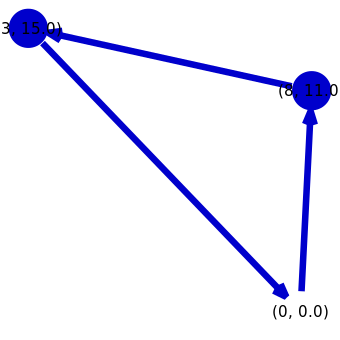

--------------------------------------------------------------------------------------------
t 3 : 


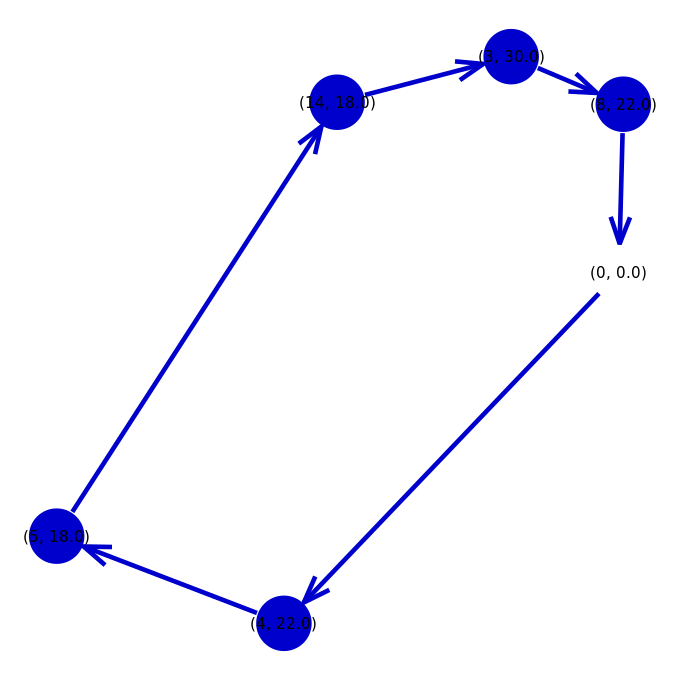

--------------------------------------------------------------------------------------------
t 5 : 


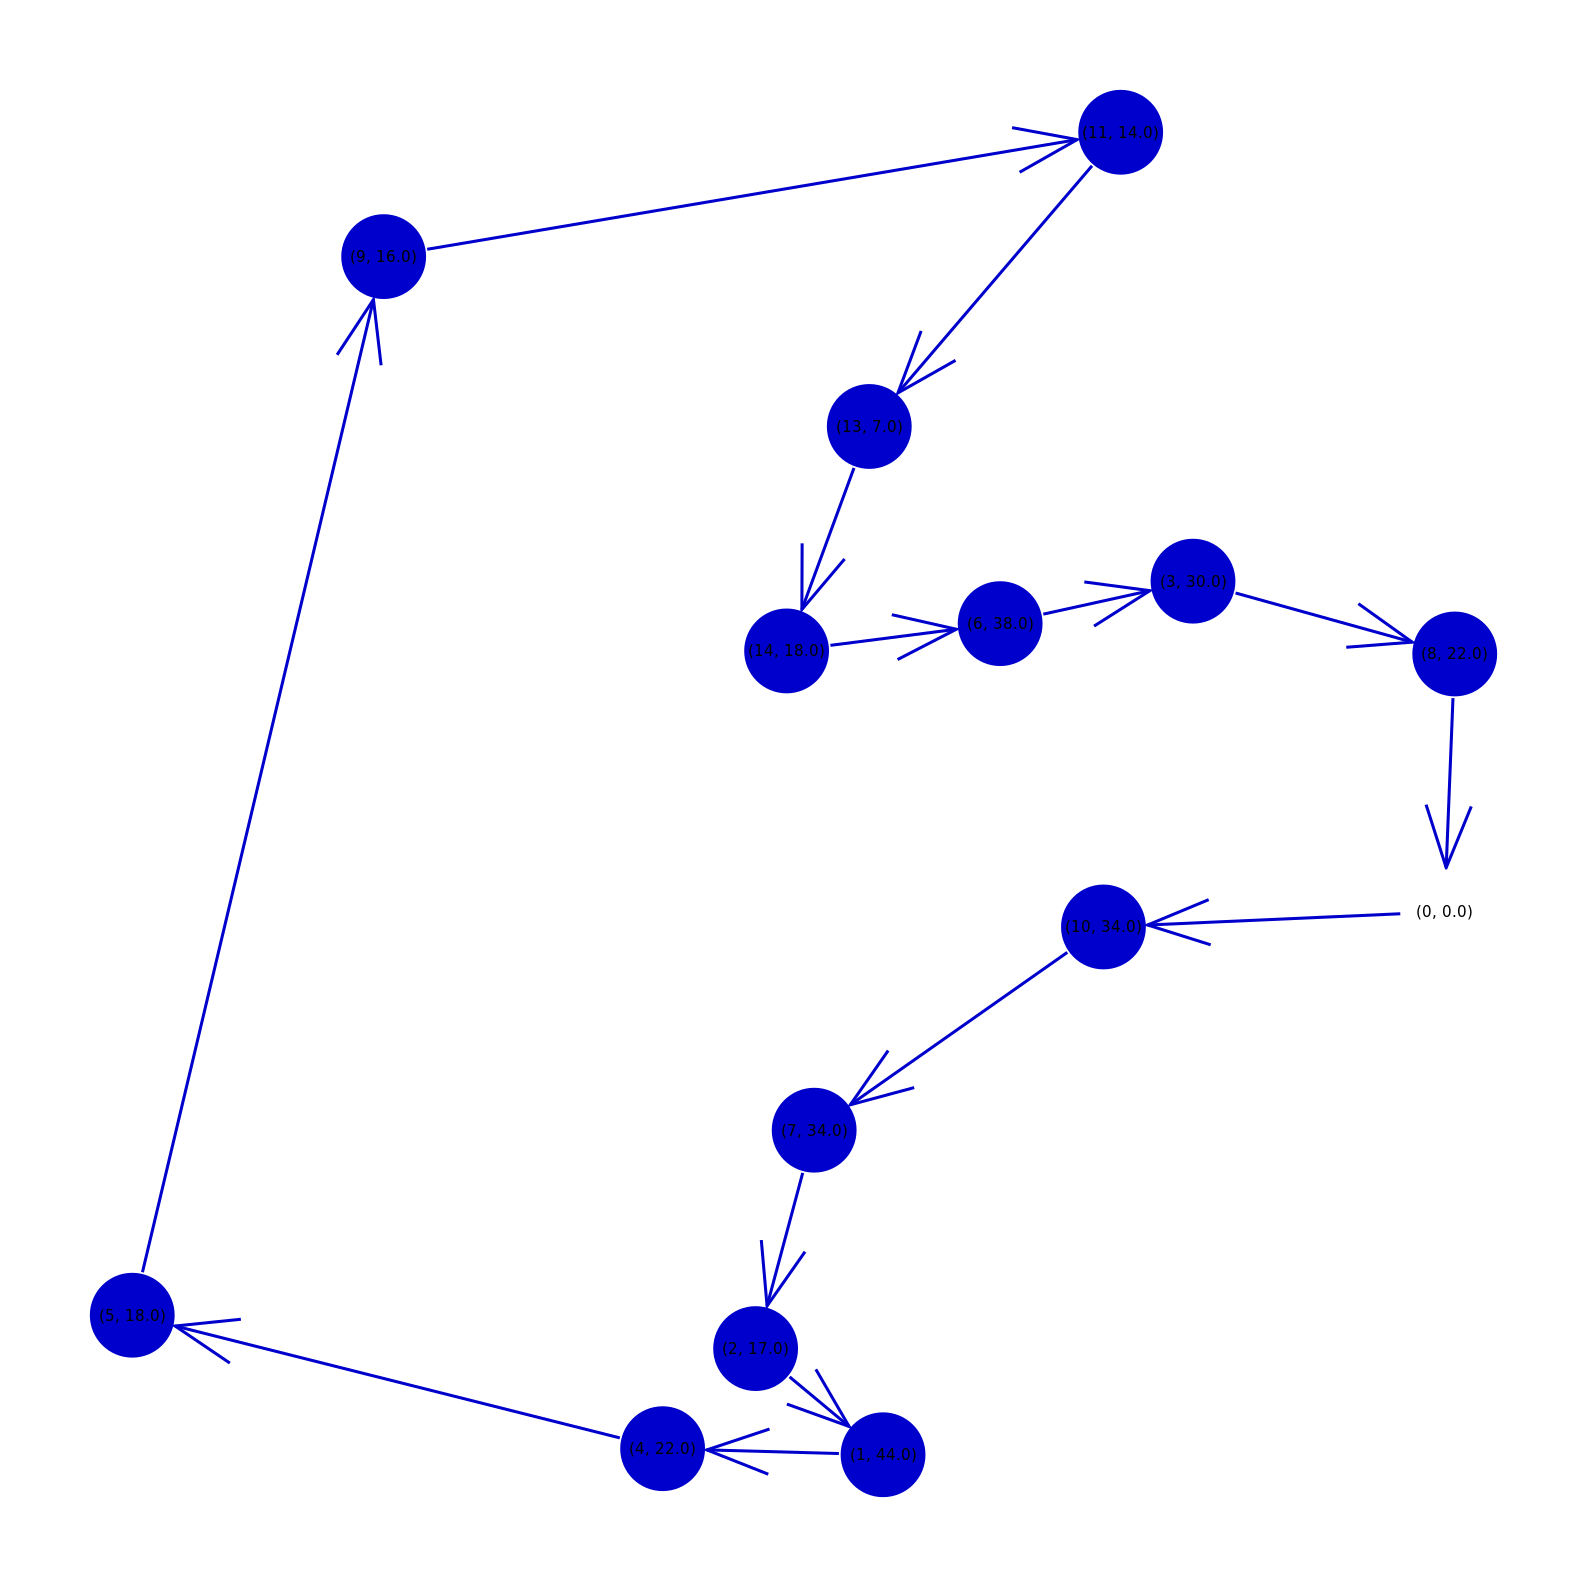

--------------------------------------------------------------------------------------------
t 6 : 


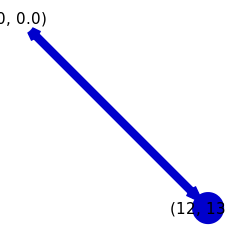

--------------------------------------------------------------------------------------------
Cost : 31107.0


In [15]:
for t in 1:l
    t_file = "log/" * file * "/t_" * string(t) * ".png"
    if isfile(t_file)
         println("t " * string(t) * " : ")
        display("image/png", read(t_file))
        println("--------------------------------------------------------------------------------------------")
    end
end
println(string("Cost : ", ccc))

In [16]:
println(string("Cost PLNE : ", ccc))
print(string("temps exec : ", time_pl))

Cost PLNE : 31107.0
temps exec : 37.937898284

<h2> Validation experimentale </h2>

<h3> 1.Comparaison de la performance des heuristiques et du PLNE </h3>

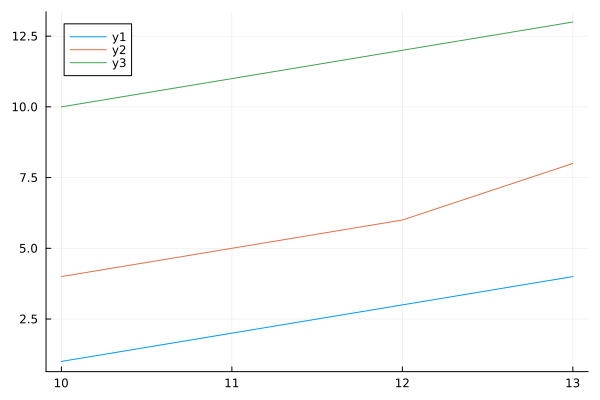

In [9]:
x=10:24
temps=hcat(temps_CW,temps_BP,temps_SECT,temps_PLNE)
couts=hcat(cout_CW,cout_BP,cout_SECT,cout_PLNE)
plot(x,temps)
plot(x,couts)
